### PVRP（期間配車計画問題）

## 定式化

$$
minimize \sum_{ij}^{}c_{ij}x_{ijt} \quad　(i<j)
$$

$$
s. t \sum_{j}^{}x_{0jt}\quad <= 2m   \quad\forall{t}\in{T})
$$

$$
 \sum_{i}^{}x_{ijt}+\sum_{j}^{}x_{jit} = 2\sum_{p}a_{ipt}y_{ip}(\forall{i,t}\in{N,T})
$$

$$
\sum_{i}^{}y_{ip}\quad = 1 \quad \forall{}
$$

In [10]:
from gurobipy import Model,quicksum,GRB
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import sys

 ## dataset

In [11]:
import random
random.seed(1)
V = [i for i in range(30)] #デポと顧客の集合
q = {} #顧客の需要
for i in V:
    q[0] = 0
    q[i] = random.randint(10,20)
np.random.seed(0)
#配列作成
x_y = np.random.rand(len(V), 2) * 100
Q = 100 #車両の最大積載量
m = 3 #車両数
day = 2
T = [0,1]#日にちの集合
a = [2 for i in range(len(V))]
li = [(1,2) for i in range(len(V))]
pat = [()]
for i in li:
    pat.append(((format(i[1],'b').zfill(a[0]))
              ,(format(i[0],'b').zfill(a[0]))))
q

{0: 0,
 1: 19,
 2: 11,
 3: 14,
 4: 11,
 5: 17,
 6: 17,
 7: 17,
 8: 20,
 9: 16,
 10: 13,
 11: 11,
 12: 17,
 13: 10,
 14: 16,
 15: 16,
 16: 19,
 17: 10,
 18: 17,
 19: 14,
 20: 13,
 21: 19,
 22: 11,
 23: 15,
 24: 10,
 25: 10,
 26: 10,
 27: 20,
 28: 18,
 29: 10}

In [12]:
pat = []
for i in range(1,len(li)):
    ll = []
    for j in range(len(li[i])):
        ll.append((format(li[i][j],'b').zfill(day)))
    pat.append(ll)
a = [()]
P = [()]
for i1 in pat:
    ml = []
    for i2 in i1[::-1]:
        ll = []
        for i3 in i2:
            ll.append(int(i3))
        ml.append(ll)
    patdata = np.array(ml)
    n_pat = [i for i in range(len(patdata))]
    #print(patdata)
    a.append(patdata)
    P.append(n_pat)

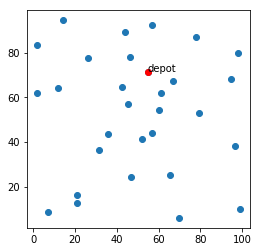

In [13]:
plt.figure(figsize=(4, 4))
plt.plot(x_y[:, 0], x_y[:, 1], 'o')
plt.plot(x_y[0][0],x_y[0][1],"ro")#デポを描画
plt.text(x_y[0][0],x_y[0][1], "depot")
plt.show()

In [14]:
x_y = np.array(x_y)
x = x_y[:, 0]
y = x_y[:, 1]
di = np.sqrt((x[:, np.newaxis] - x[np.newaxis, :]) ** 2 +(y[:, np.newaxis] - y[np.newaxis, :]) ** 2)
Route = {(i,j) for i in V for j in V}

In [15]:
#Parameter
c = {} #移動間のコスト
for i in range(len(x_y)):
    for j in range(len(x_y)):
        c[i,j] = di[i,j]

 # Gurobiで解く

In [16]:
import math
import random
import networkx
from gurobipy import *

In [17]:
def vrp_callback(model,where):
    if where != GRB.callback.MIPSOL:#新しい解を発見した時だけ部分巡回路除去制約を追加
        return
    for t in T:
        edges = []
        for (i,j,t2) in x:
            if model.cbGetSolution(x[i,j,t]) > .5:
                if t == t2 and i != V[0] and j != V[0]:
                    edges.append( (i,j) )
        G = networkx.Graph()
        G.add_edges_from(edges)
        Components = networkx.connected_components(G)
        for S in Components:
            S_card = len(S)
            q_sum = sum(q[i] for i in S)
            NS = int(math.ceil(float(q_sum)/Q))
            S_edges = [(i,j) 
                       for i in S 
                       for j in S
                       if i<j and (i,j) in edges]
            if S_card >= 3 and (len(S_edges) >= S_card or NS > 1):
                model.cbLazy(quicksum(x[i,j,t]
                                      for i in S 
                                      for j in S 
                                      for t in T 
                                      if j > i) <= S_card-NS)
                #print ("adding cut for" , S_edges)
    return

In [18]:
model = Model("vrp")

Academic license - for non-commercial use only


In [94]:
#変数
x = {}
for i in V:
    for j in V:
        for t in T:
            if j > i and i == V[0]:       # depot
                x[i,j,t] = model.addVar(ub=2, vtype="I", name="x(%s,%s,%s)"%(i,j,t))
            elif j > i:
                x[i,j,t] = model.addVar(ub=1, vtype="I", name="x(%s,%s,%s)"%(i,j,t))


model.update()
#for (i,j,t) in x:
#    print(x[i,j,t])

In [95]:
y = {}
for i in V:
    for p in P[i]:
        y[i,p] = model.addVar(vtype="B",name = f"y[{i},{p}]")
model.update()
#for (i,p) in y:
#    print(y[i,p])

In [96]:
#制約
    
#トラックがデポから出発する制約
for t in T:
    model.addConstr(quicksum(x[V[0],j,t] for j in V[1:]) <= 2*m )

#必ず一台の車両により顧客へのサービスが行われる割り当て制約
for i in V[1:]:
    for t in T:
        model.addConstr(quicksum(x[j,i,t] for j in V if j < i) +
                        quicksum(x[i,j,t] for j in V if j > i) == 
                        2 * quicksum(a[i][p][t]* y[i,p]for p in P[i]))

#必ず全ての顧客を回る制約
for i in V[1:]:
    model.addConstr(quicksum(y[i,p] for p in P[i]) == 1)

model.update()

In [97]:
#目的関数
model.setObjective(quicksum(c[i,j]*x[i,j,t] 
                            for i in V
                            for j in V 
                            for t in T
                            if j>i), GRB.MINIMIZE)

model.update()
#model.__data = x

In [98]:
if __name__ == "__main__":
    import sys
    model.params.DualReductions = 0
    model.params.LazyConstraints = 1
    model.optimize(vrp_callback)
    #model.optimize()
    #x = model.__data

    for t in T:
        edges = []
        for (i,j,t2) in x:
            if x[i,j,t].X > .5:
                if t2 == t and i != V[0] and j != V[0]:
                        edges.append( (i,j) )

    print ("Optimal solution:",model.ObjVal)
    print ("Edges in the solution:")
    print (sorted(edges))

Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 89 rows, 928 columns and 1856 nonzeros
Variable types: 0 continuous, 928 integer (58 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [3e+00, 1e+02]
  Bounds range     [1e+00, 2e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 29 rows and 29 columns
Presolve time: 0.01s
Presolved: 60 rows, 899 columns, 1798 nonzeros
Variable types: 0 continuous, 899 integer (841 binary)

Root relaxation: objective 4.242329e+02, 88 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  424.23293    0   33          -  424.23293      -     -    0s
     0     0  514.47908    0   31          -  514.47908      -     -    0s
     0     0  523

In [99]:
#変数の確認
for v in model.getVars():
    if v.X> 0:
        print(v.VarName, v.X)

x(0,2,1) 1.0
x(0,5,0) 1.0
x(0,6,0) 1.0
x(0,11,0) 1.0
x(0,14,0) 1.0
x(0,15,0) 1.0
x(0,18,1) 1.0
x(0,20,1) 1.0
x(0,22,0) 1.0
x(0,25,1) 1.0
x(1,16,1) 1.0
x(1,18,1) 1.0
x(2,16,1) 1.0
x(3,11,0) 1.0
x(3,13,0) 1.0
x(4,5,0) 1.0
x(4,26,0) 1.0
x(6,9,0) 1.0
x(7,23,1) 1.0
x(7,27,1) 1.0
x(8,13,0) 1.0
x(8,17,0) 1.0
x(9,10,0) 1.0
x(10,19,0) 1.0
x(12,15,0) 1.0
x(12,17,0) 1.0
x(14,28,0) 1.0
x(19,22,0) 1.0
x(20,24,1) 1.0
x(21,26,0) 1.0
x(21,28,0) 1.0
x(23,29,1) 1.0
x(24,27,1) 1.0
x(25,29,1) 1.0
y[1,1] 1.0
y[2,1] 1.0
y[3,0] 1.0
y[4,0] 1.0
y[5,0] 1.0
y[6,0] 1.0
y[7,1] 1.0
y[8,0] 1.0
y[9,0] 1.0
y[10,0] 1.0
y[11,0] 1.0
y[12,0] 1.0
y[13,0] 1.0
y[14,0] 1.0
y[15,0] 1.0
y[16,1] 1.0
y[17,0] 1.0
y[18,1] 1.0
y[19,0] 1.0
y[20,1] 1.0
y[21,0] 1.0
y[22,0] 1.0
y[23,1] 1.0
y[24,1] 1.0
y[25,1] 1.0
y[26,0] 1.0
y[27,1] 1.0
y[28,0] 1.0
y[29,1] 1.0


In [68]:
print ("Optimal solution:",model.ObjVal)

Optimal solution: 483.17133062417514


In [56]:
import math
import random
import networkx
from gurobipy import *

def vrp(V,c,m,q,Q,T,P):
    
    def vrp_callback(model,where):
        if where != GRB.callback.MIPSOL:#新しい解を発見した時だけ部分巡回路除去制約を追加
            return
        for t in T:
            edges = []
            for (i,j,t2) in x:
                if model.cbGetSolution(x[i,j,t]) > .5:
                    if t == t2 and i != V[0] and j != V[0]:
                        edges.append( (i,j) )
            #print("#############")
            G = networkx.Graph()
            G.add_edges_from(edges)
            Components = networkx.connected_components(G)
            for S in Components:
                S_card = len(S)
                q_sum = sum(q[i] for i in S)
                NS = int(math.ceil(float(q_sum)/Q))
                S_edges = [(i,j) 
                           for i in S 
                           for j in S
                           if i<j and (i,j) in edges]
                if S_card >= 3 and (len(S_edges) >= S_card or NS > 1):
                    model.cbLazy(quicksum(x[i,j,t]
                                          for i in S 
                                          for j in S 
                                          for t in T 
                                          if j > i) <= S_card-NS)
                    #print ("adding cut for" , S_edges)
        return


    model = Model("vrp")
    
    #変数
    
    x = {}
    for i in V:
        for j in V:
            for t in T:
                if j > i and i == V[0]:       # depot
                        x[i,j,t] = model.addVar(ub=2, vtype="I", name="x(%s,%s,%s)"%(i,j,t))
                elif j > i:
                    x[i,j,t] = model.addVar(ub=1, vtype="I", name="x(%s,%s,%s)"%(i,j,t))

    #print(x)
    y = {}
    for i in V:
        for p in P[i]:
            y[i,p] = model.addVar(vtype="B",name = f"y[{i},{p}]")
    #print(y)
    model.update()
    
    #制約
    
    #トラックがデポから出発する制約
    for t in T:
        model.addConstr(quicksum(x[V[0],j,t] for j in V[1:]) <= 2*m )
        
    #必ず一台の車両により顧客へのサービスが行われる割り当て制約
    for i in V[1:]:
        for t in T:
            model.addConstr(quicksum(x[j,i,t] for j in V if j < i) +
                            quicksum(x[i,j,t] for j in V if j > i) == 
                            2 * quicksum(a[i][p][t]* y[i,p]for p in P[i]))
            
    #必ず全ての顧客を回る制約
    for i in V[1:]:
        model.addConstr(quicksum(y[i,p] for p in P[i]) == 1)
        
    model.update()
    
    #目的関数
    model.setObjective(quicksum(c[i,j]*x[i,j,t] 
                                for i in V
                                for j in V 
                                for t in T
                                if j>i), GRB.MINIMIZE)

    model.update()
    model.__data = x
    return model,vrp_callback



    
            
if __name__ == "__main__":
    import sys

    model,vrp_callback = vrp(V,c,m,q,Q,T,P)

    model.params.DualReductions = 0
    model.params.LazyConstraints = 1
    model.optimize(vrp_callback)
    x = model.__data
    
    """for t in T:
        edges = []
        for (i,j,t2) in x:
            if x[i,j,t2].X > 5:
                if t2 == t and i != V[0] and j != V[0]:
                    edges.append( (i,j) )"""

    print ("Optimal solution:",model.ObjVal)
    print ("Edges in the solution:")
    print (sorted(edges))

Changed value of parameter DualReductions to 0
   Prev: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter LazyConstraints to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Optimize a model with 59 rows, 418 columns and 836 nonzeros
Variable types: 0 continuous, 418 integer (38 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [7e+00, 1e+02]
  Bounds range     [1e+00, 2e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 19 rows and 19 columns
Presolve time: 0.01s
Presolved: 40 rows, 399 columns, 798 nonzeros
Variable types: 0 continuous, 399 integer (361 binary)

Root relaxation: objective 3.614545e+02, 49 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  361.45451    0   16          -  361.45451      -     -    0s
     0     0  395.71121    0    6          -  395.71121      -     -    0s
     0     0  419.6

In [57]:
opt = model.ObjVal
print(f"最適距離: {opt}")

最適距離: 483.17133062417514


In [58]:
#変数の確認
for v in model.getVars():
    if v.X> 0:
        print(v.VarName, v.X)

x(0,2,0) 1.0
x(0,5,1) 1.0
x(0,6,1) 1.0
x(0,11,0) 1.0000000000000058
x(0,15,0) 1.0
x(0,18,0) 1.0
x(1,14,0) 0.9999999999999928
x(1,18,0) 1.0
x(2,16,0) 1.0
x(3,11,0) 0.9999999999999942
x(3,13,0) 1.0000000000000013
x(4,5,1) 1.0000000000000002
x(4,19,1) 0.9999999999999998
x(6,9,1) 1.0
x(7,14,0) 1.0
x(7,16,0) 1.0000000000000016
x(8,13,0) 1.000000000000001
x(8,17,0) 1.0000000000000044
x(9,10,1) 0.9999999999999989
x(10,19,1) 0.9999999999999989
x(12,15,0) 1.0
x(12,17,0) 1.0
y[1,0] 0.9999999999999964
y[1,1] 3.552713678800501e-15
y[2,0] 1.0
y[3,0] 1.0
y[4,1] 1.0
y[5,1] 1.0
y[6,1] 1.0
y[7,0] 1.0
y[8,0] 1.0000000000000027
y[9,1] 1.0
y[10,1] 1.0
y[11,0] 1.0
y[12,0] 1.0
y[13,0] 1.0
y[14,0] 1.0
y[15,0] 1.0
y[16,0] 1.0
y[17,0] 1.0
y[18,0] 1.0
y[19,1] 1.0


 # ルートの可視化

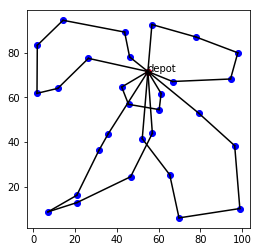

In [107]:
plt.figure(figsize=(4, 4))
plt.scatter(x_y[:, 0], x_y[:, 1], c='b')
#plt.text(x_y[:,0]+1,x_y[:,1]+1, str(V[0:]))
plt.scatter(x_y[0][0],x_y[0][1],c="r")#デポを描画
plt.text(x_y[0][0],x_y[0][1], "depot")

for t in T:
    for i in V:
        for j in V:
            if i < j and x[i,j,t].x >= 0.9:
                plt.plot([x_y[i][0],x_y[j][0]], [x_y[i][1], x_y[j][1]], c="black")
plt.show()

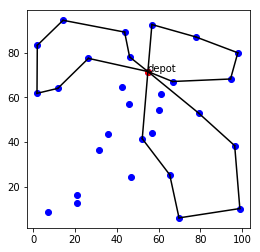

In [108]:
#１日目
plt.figure(figsize=(4, 4))
plt.scatter(x_y[:, 0], x_y[:, 1], c='b')
#plt.text(x_y[:,0]+1,x_y[:,1]+1, str(V[0:]))
plt.scatter(x_y[0][0],x_y[0][1],c="r")#デポを描画
plt.text(x_y[0][0],x_y[0][1], "depot")

for t in T:
    if t == 0:
        for i in V:
            for j in V:
                if i < j and x[i,j,t].x >= 0.9:
                    plt.plot([x_y[i][0],x_y[j][0]], [x_y[i][1], x_y[j][1]], c="black")
plt.show()

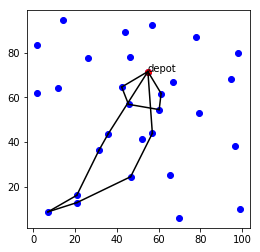

In [109]:
#2日目
plt.figure(figsize=(4, 4))
plt.scatter(x_y[:, 0], x_y[:, 1], c='b')
#plt.text(x_y[:,0]+1,x_y[:,1]+1, str(V[0:]))
plt.scatter(x_y[0][0],x_y[0][1],c="r")#デポを描画
plt.text(x_y[0][0],x_y[0][1], "depot")

for t in T:
    if t == 1:
        for i in V:
            for j in V:
                if i < j and x[i,j,t].x >= 0.9:
                    plt.plot([x_y[i][0],x_y[j][0]], [x_y[i][1], x_y[j][1]], c="black")
plt.show()